# VGG
-----

### Set Up
-----

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import joblib
import math
import seaborn as sns


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

In [3]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

### Utility Functions


In [7]:
def img_resize(X_data, new_height, new_width, rgb= True):

    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

### Setting up VGG 16

In [31]:
from tensorflow.keras.applications.vgg16 import VGG16

In [32]:
y = joblib.load( '../../model/my_files/y.pkl' )

In [33]:
num_output_classes = len(np.unique(y))

In [34]:
my_vgg = keras.applications.VGG16(include_top=False, # Set to false to only load the conv layers, will be swapping out the top layers for ownß
                                     weights='imagenet', 
                                     input_tensor=None,
                                     input_shape=(64,64,3), # changing input shape to (32,32,3) 32 is minimium size
                                     pooling=max, # for my output will use pooling
                                     classes= num_output_classes, # setting to len of my y (24)
                                     classifier_activation='softmax' # keep as softmax for output layer
                                 )


In [35]:
my_vgg.trainable = False # freezing weights was I am using weights from imagenet so they are not refreshed 

In [36]:
my_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

### Adding my own top layers

In [37]:
my_model = Sequential([my_vgg,
                       layers.Flatten(),
                       layers.Dense(128, activation='relu'),
                       layers.Dense(64, activation="relu"),
                       layers.Dense(num_output_classes, activation="softmax")
                       ])



In [38]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 24)                1560      
                                                                 
Total params: 14,986,776
Trainable params: 272,088
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

### Train model using the original MNIST data

In [40]:
X = joblib.load( '../../model/my_files/X.pkl')
y = joblib.load( '../../model/my_files/y.pkl')

In [41]:
X.shape

(34627, 784)

In [42]:
y.shape

(34627,)

In [43]:
X = X.reshape(-1,28,28)
X.shape

(34627, 28, 28)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [45]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255
# Sanity Check
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


In [46]:
X_train_resized = img_resize(X_train, 64, 64)
X_val_resized = img_resize(X_val, 64, 64)

In [47]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [48]:
history = my_model.fit(X_train_resized, y_train,
                        batch_size = 128,
                        epochs = 20,
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks=[early_stop])

Epoch 1/20
174/174 [==============================] - 282s 2s/step - loss: 1.1311 - accuracy: 0.7132 - val_loss: 0.3172 - val_accuracy: 0.9341
Epoch 2/20
174/174 [==============================] - 311s 2s/step - loss: 0.1691 - accuracy: 0.9771 - val_loss: 0.0905 - val_accuracy: 0.9910
Epoch 3/20
174/174 [==============================] - 315s 2s/step - loss: 0.0581 - accuracy: 0.9964 - val_loss: 0.0422 - val_accuracy: 0.9966
Epoch 4/20
174/174 [==============================] - 302s 2s/step - loss: 0.0289 - accuracy: 0.9986 - val_loss: 0.0195 - val_accuracy: 0.9995
Epoch 5/20
174/174 [==============================] - 312s 2s/step - loss: 0.0153 - accuracy: 0.9996 - val_loss: 0.0129 - val_accuracy: 0.9998
Epoch 6/20
174/174 [==============================] - 302s 2s/step - loss: 0.0104 - accuracy: 0.9998 - val_loss: 0.0090 - val_accuracy: 0.9996
Epoch 7/20
174/174 [==============================] - 270s 2s/step - loss: 0.0066 - accuracy: 0.9999 - val_loss: 0.0070 - val_accuracy: 0.9996

In [49]:
my_model.save('../../model/my_files/my_VGG_model.h5')

In [50]:
train_loss, train_acc = my_model.evaluate(X_train_resized, y_train)
print('Train accuracy:', train_acc)

866/866 [==============================] - 225s 260ms/step - loss: 5.8219e-04 - accuracy: 1.0000
Train accuracy: 0.9999638795852661


In [51]:
# Evaluate the model's performance
val_loss, val_acc= my_model.evaluate(X_val_resized, y_val, verbose=1)
print('Test accuracy:', val_acc)

217/217 [==============================] - 64s 294ms/step - loss: 0.0011 - accuracy: 1.0000
Test accuracy: 1.0


### Model Performance

In [52]:
my_model = load_model('../../model/my_files/my_VGG_model.h5')

In [53]:
unique_values = np.unique(y_val)

217/217 [==============================] - 65s 297ms/step


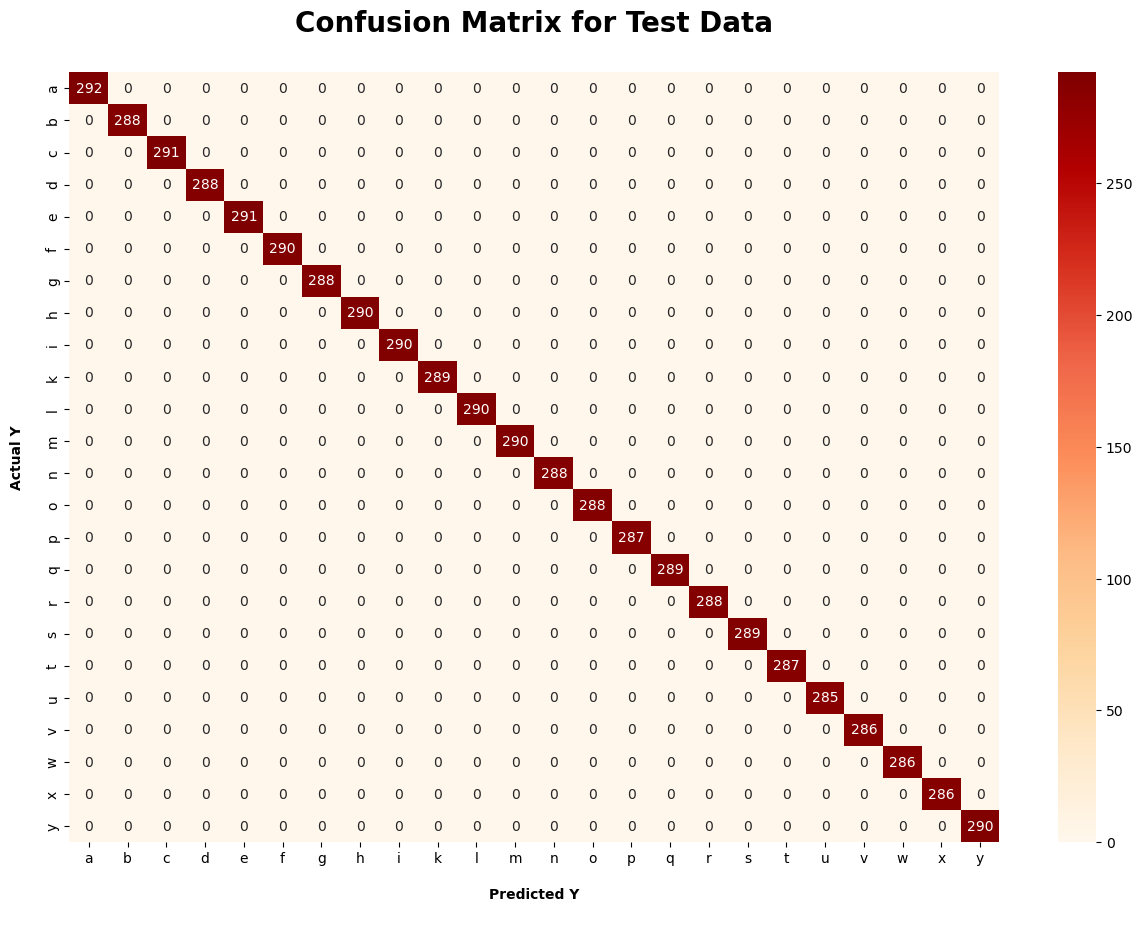

In [54]:
pred_y = np.argmax(my_model.predict(X_val_resized), axis=1)
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Visualising Misclassifications

In [55]:
incorrect_photos = (y_val != pred_y)

In [57]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

if num_photos == 0:
    print('There are no misclassifications to show!')
else:
    fig, axes = plt.subplots(rows,5, figsize=(20,4*rows))

    ax = axes.flatten()

    for i, image in enumerate(X_val[incorrect_photos]):
        ax[i].imshow(image, cmap='gray')

        # Get predicted label
        p = pred_y[incorrect_photos][i]
        prediction = alphabet[p]

        # Get actual label
        t = y_val[incorrect_photos][i]
        actual = alphabet[t.astype(np.int32)]

        # Set the title of the subplot
        ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

        # Hide the x and y ticks to make
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.tight_layout()
    plt.show()


There are no misclassifications to show!


## Data Augmentation
-----

In [58]:
my_model = load_model('../../model/my_files/my_VGG_model.h5')

In [59]:
train_datagen = joblib.load('../../model/my_files/train_datagen.pkl') 
val_datagen = joblib.load('../../model/my_files/val_datagen.pkl') 

In [60]:
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_resized, y_val, batch_size=32)

In [63]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [62]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [65]:
my_model.fit(train_generator,
              steps_per_epoch=len(train_generator),
              epochs=20,
              validation_data=val_generator,
              validation_steps=len(val_generator),
              callbacks=[early_stop]
    )

Epoch 1/20
866/866 [==============================] - 298s 344ms/step - loss: 3.4342 - accuracy: 0.0421 - val_loss: 3.3003 - val_accuracy: 0.0411
Epoch 2/20
866/866 [==============================] - 351s 405ms/step - loss: 3.2370 - accuracy: 0.0429 - val_loss: 3.1841 - val_accuracy: 0.0417
Epoch 3/20
866/866 [==============================] - 354s 408ms/step - loss: 3.1806 - accuracy: 0.0396 - val_loss: 3.1782 - val_accuracy: 0.0419
Epoch 4/20
866/866 [==============================] - 349s 404ms/step - loss: 3.1785 - accuracy: 0.0397 - val_loss: 3.1781 - val_accuracy: 0.0420
Epoch 5/20
866/866 [==============================] - 344s 397ms/step - loss: 3.1784 - accuracy: 0.0412 - val_loss: 3.1780 - val_accuracy: 0.0420
Epoch 6/20
866/866 [==============================] - 378s 436ms/step - loss: 3.1784 - accuracy: 0.0405 - val_loss: 3.1781 - val_accuracy: 0.0417
Epoch 7/20
866/866 [==============================] - ETA: 0s - loss: 3.1784 - accuracy: 0.0399

KeyboardInterrupt: 

In [30]:
my_model.save('../../model/my_files/my_VGG_model_AUG.h5')

In [31]:
train_loss, train_acc = my_model.evaluate(train_generator)
print('Train accuracy:', train_acc)

866/866 [==============================] - 57s 66ms/step - loss: 0.2365 - accuracy: 0.9192
Train accuracy: 0.9192447662353516


In [32]:
val_loss, val_acc = my_model.evaluate(val_generator)
print('Test accuracy:', val_acc)

217/217 [==============================] - 15s 67ms/step - loss: 0.0681 - accuracy: 0.9805
Test accuracy: 0.9805082082748413


## Top Up Training using Teachable Machine
----

https://keras.io/guides/transfer_learning/

In [66]:
# load the base VGG model
base_vgg_model = load_model('../../model/my_files/my_VGG_model.h5')

In [67]:
# unfreeze the base model weights
base_vgg_model.trainable = True

In [68]:
# recompile the model
base_vgg_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [74]:
directory = '../../model/real_world_imgs/'
my_imgs = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True, 
    seed=1
)

Found 7866 files belonging to 24 classes.


In [78]:
train_data, val_data = keras.utils.split_dataset(my_imgs, right_size= 0.2)

In [79]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [80]:
history = base_vgg_model.fit(train_data,
                        batch_size = 128,
                        epochs = 20,
                        verbose = 1,
                        validation_data = val_data,
                        callbacks=[early_stop])

Epoch 1/20


TypeError: 'NoneType' object is not callable

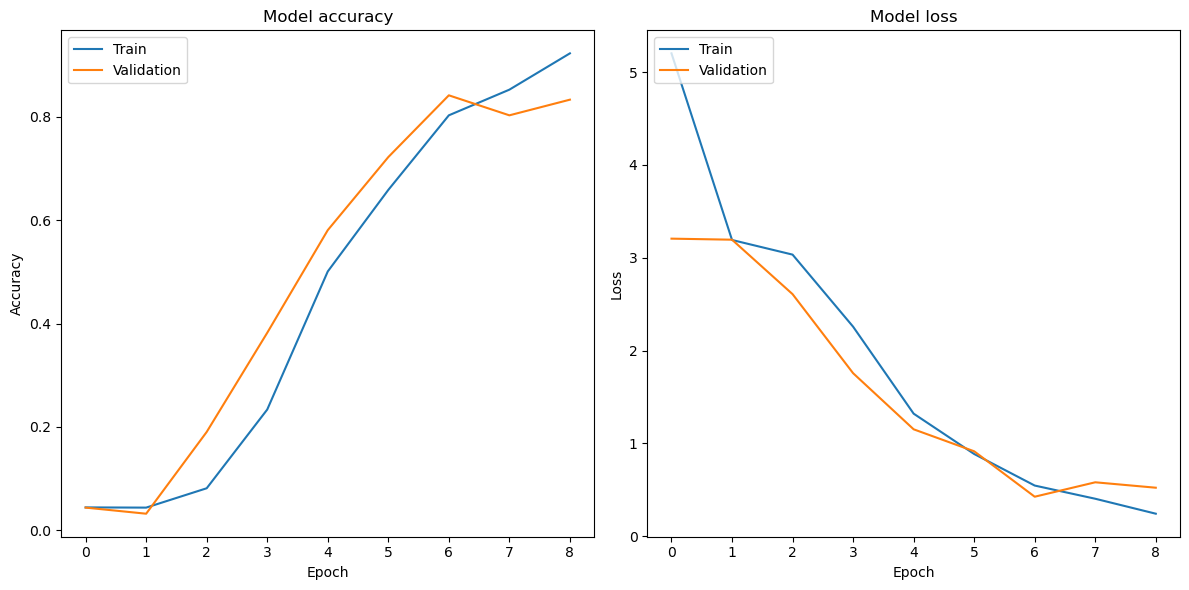

In [99]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# epochs 18

In [100]:
train_loss, train_acc= base_vgg_model.evaluate(train_data)
print('Train accuracy:', train_acc)

75/75 [==============================] - 5s 64ms/step - loss: 0.4716 - accuracy: 0.8695
Train accuracy: 0.869528591632843


In [101]:
val_loss, val_acc= base_vgg_model.evaluate(val_data)
print('Test accuracy:', val_acc)

19/19 [==============================] - 1s 62ms/step - loss: 0.5234 - accuracy: 0.8333
Test accuracy: 0.8333333134651184


In [102]:
base_vgg_model.save('../../model/my_files/top_up_VGG.h5')

In [13]:
base_vgg_model =load_model('../../model/my_files/top_up_VGG.h5')

## Model Performance

### Confusion Matrix

In [32]:
pred_y = np.argmax(base_vgg_model.predict(val_data), axis=1)

19/19 [==============================] - 1s 74ms/step


In [33]:
pred_y.shape

(594,)

In [34]:
val_labels = []
for img, label in val_data:
    val_labels.append(label.numpy())

In [35]:
val_labels = np.concatenate(val_labels)

In [39]:
val_labels.shape

(594,)

In [38]:
pred_y.shape

(594,)

In [46]:
import seaborn as sns

In [47]:
unique_values = np.unique(val_labels)
unique_values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

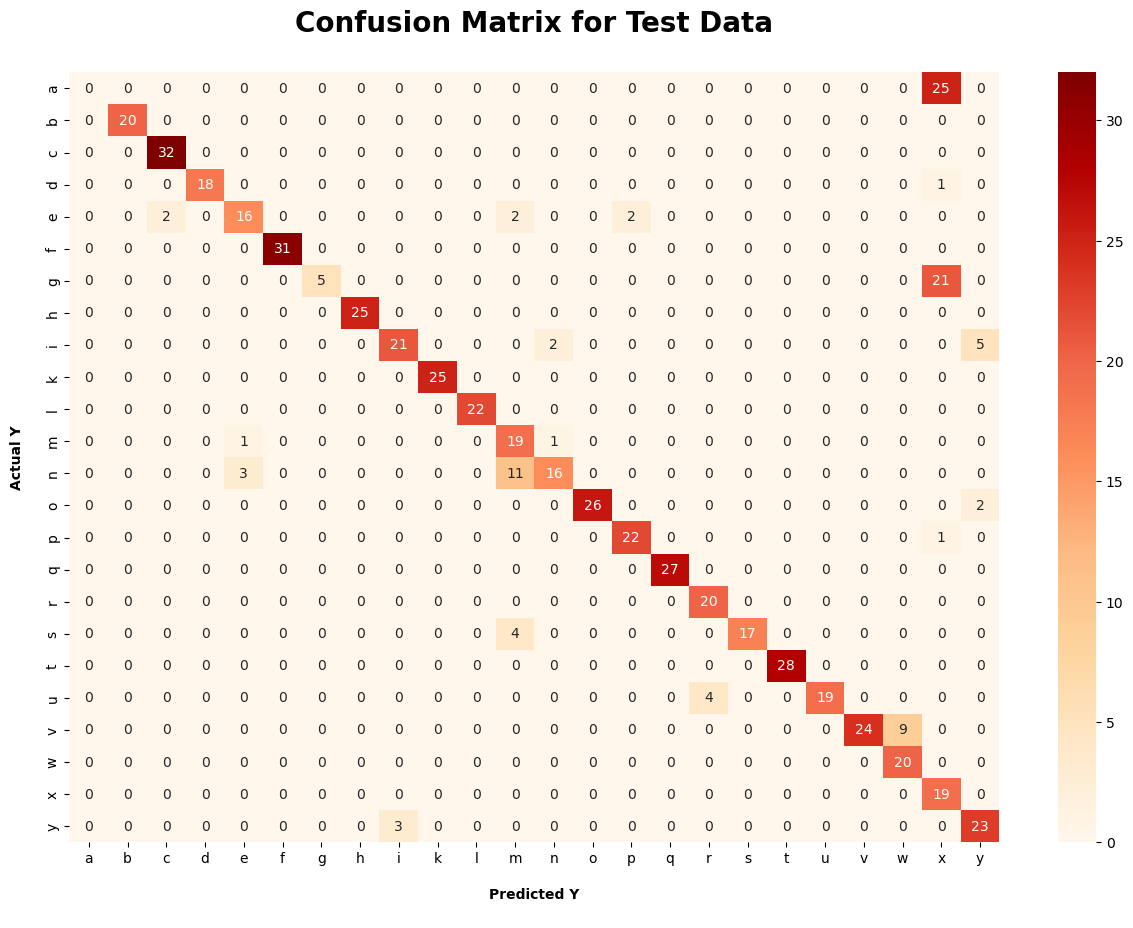

In [50]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(val_labels, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Visualising Misclassifications

In [ ]:
X_val

In [52]:
incorrect_photos = (val_labels != pred_y)

NameError: name 'X_val' is not defined

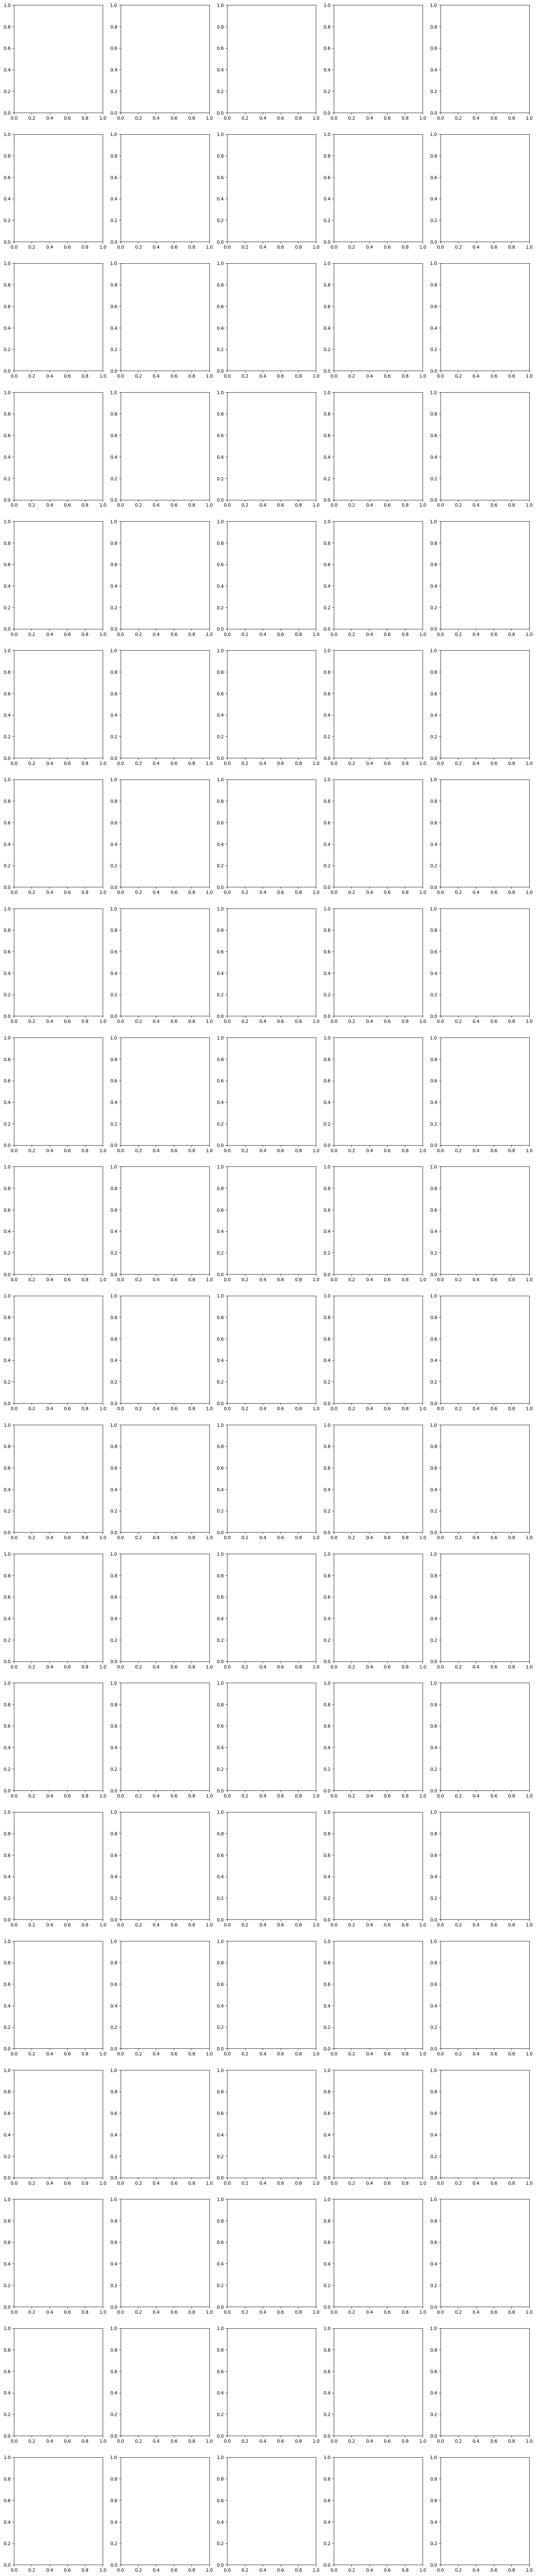

In [54]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

fig, axes = plt.subplots(rows,5, figsize=(20, 100))

ax = axes.flatten()

for i, image in enumerate(X_val[incorrect_photos]):
    ax[i].imshow(image, cmap='gray')

    # Get predicted label
    p = pred_y[incorrect_photos][i]
    prediction = alphabet[p]

    # Get actual label
    t = val_labels[incorrect_photos][i]
    actual = alphabet[t.astype(np.int32)]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()


In [56]:
ßtop_up = load_model('../../model/my_files/top_up_VGG.h5')

In [57]:
top_up.evaluate(train_data)

75/75 [==============================] - 5s 64ms/step - loss: 6.0396e-05 - accuracy: 1.0000


[6.039566869731061e-05, 1.0]

In [58]:
top_up.evaluate(val_data)

19/19 [==============================] - 1s 63ms/step - loss: 3.1048e-04 - accuracy: 1.0000


[0.0003104759962297976, 1.0]